In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country'] # If the y_label is discrete column do not include it in this list
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
for i in train_data['income']:
    if i == '<=50K':
        train_data['income'] = train_data['income'].replace(i, 0)
    else:
        train_data['income'] = train_data['income'].replace(i, 1)

<ipython-input-4-799530806>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['income'] = train_data['income'].replace(i, 1)


#Load Drive and Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

In [ ]:
import os
os.chdir('/content/drive/My Drive/TabDDPM')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/TabDDPM')

In [ ]:
#For uploading a custom dataset

filename = "..."   # use the name .csv file: nameOfDataset.csv

# Check if the file already exists
if not os.path.exists(filename):
    print(f"{filename} not found. Please upload it.")
    files.upload()

train_data = pd.read_csv(filename)
train_data = train_data.dropna().reset_index(drop=True)
attributes_to_ignore = ['...']
train_data = train_data.drop(attributes_to_ignore, axis=1)
discrete_columns = ['...'] # If the y_label is discrete, do not include it in this list. Also, trandform its values to numbers for classification
train_data

#My dataset

In [ ]:
nameOfDataset="adult"

!mkdir Results

%cd data
!mkdir {nameOfDataset}
%cd ..
%cd exp
!mkdir {nameOfDataset}
%cd ..

mkdir: cannot create directory ‘Results’: File exists
/content/drive/My Drive/TabDDPM/data
mkdir: cannot create directory ‘adult’: File exists
/content/drive/My Drive/TabDDPM
/content/drive/My Drive/TabDDPM/exp
mkdir: cannot create directory ‘adult’: File exists
/content/drive/My Drive/TabDDPM


In [ ]:
nameOfTest="adultTest"

%cd Results
!mkdir {nameOfTest}
%cd {nameOfTest}
!mkdir Real
%cd ..
%cd ..

/content/drive/My Drive/TabDDPM/Results
mkdir: cannot create directory ‘adultTest’: File exists
/content/drive/My Drive/TabDDPM/Results/adultTest
mkdir: cannot create directory ‘Real’: File exists
/content/drive/My Drive/TabDDPM/Results
/content/drive/My Drive/TabDDPM


In [ ]:
def train_validate_test_split(df, train_percent=0.99, validate_percent=0.01, seed=1):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, train_end, validate, validate_end-train_end, test, m-validate_end

trainingSet, train_size, ValidationSet, val_size, testSet, test_size = train_validate_test_split(train_data,seed=5)

In [ ]:
def pandasDataFrameToNumpy(nameOfDataset, nameOfTest, trainingSet, ValidationSet, testSet):

    ##Training Set To Numpy in folder "Results\nameOfTest\Real\"
    labels= trainingSet.iloc[:,-1]
    label_c_name = labels.name
    trainingData = trainingSet.drop(trainingSet.columns[-1],axis = 1)
    categoricalData = trainingSet[discrete_columns]
    cat_c_names = list(categoricalData.columns)
    numericalData = trainingData.drop(discrete_columns,axis = 1)
    num_c_names = list(numericalData.columns)
    numericalData = numericalData.to_numpy(dtype='float32')


    d_dir = os.path.join("data", nameOfDataset)
    if not os.path.exists(d_dir):
        os.makedirs(d_dir)
    r_dir = os.path.join("Results", nameOfTest, "Real")
    if not os.path.exists(r_dir):
        os.makedirs(r_dir)

    np.save(os.path.join(d_dir, "X_num_train.npy"), numericalData)
    np.save(os.path.join(d_dir, "X_cat_train.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(d_dir, "y_train.npy"), labels)

    np.save(os.path.join(r_dir, "X_num_train.npy"), numericalData)
    np.save(os.path.join(r_dir, "X_cat_train.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(r_dir, "y_train.npy"), labels)

    ##Validation Set To Numpy in folder "Results\nameOfTest\Real\"
    labels= ValidationSet.iloc[:,-1]
    validationData = ValidationSet.drop(ValidationSet.columns[-1],axis = 1)
    categoricalData = validationData[discrete_columns]
    numericalData = validationData.drop(discrete_columns,axis = 1)
    numericalData = numericalData.to_numpy(dtype='float32')

    np.save(os.path.join(d_dir, "X_num_val.npy"), numericalData)
    np.save(os.path.join(d_dir, "X_cat_val.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(d_dir, "y_val.npy"), labels)

    np.save(os.path.join(r_dir, "X_num_val.npy"), numericalData)
    np.save(os.path.join(r_dir, "X_cat_val.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(r_dir, "y_val.npy"), labels)


    ##Test Set To Numpy in folder "Results\nameOfTest\Real\"
    labels= testSet.iloc[:,-1]
    testData = testSet.drop(testSet.columns[-1],axis = 1)
    categoricalData = testData[discrete_columns]
    numericalData = testData.drop(discrete_columns,axis = 1)
    numericalData = numericalData.to_numpy(dtype='float32')


    np.save(os.path.join(d_dir, "X_num_test.npy"), numericalData)
    np.save(os.path.join(d_dir, "X_cat_test.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(d_dir, "y_test.npy"), labels)

    np.save(os.path.join(r_dir, "X_num_test.npy"), numericalData)
    np.save(os.path.join(r_dir, "X_cat_test.npy"), categoricalData, allow_pickle=True)
    np.save(os.path.join(r_dir, "y_test.npy"), labels)

    column_names = cat_c_names + num_c_names + [label_c_name]
    return column_names

In [ ]:
column_names = pandasDataFrameToNumpy(nameOfDataset, nameOfTest, trainingSet, ValidationSet, testSet)

In [ ]:
column_names

In [ ]:
#use your nameOfDataset and nameOfTest and adjust your parameters

toml_text = """
seed = 1
parent_dir = "exp/adult/adultTest"
real_data_path = "data/adult/"
model_type = "mlp"
num_numerical_features = 4
device = "cuda:0"

[model_params]
num_classes=2
is_y_cond = true

[model_params.rtdl_params]
d_layers = [
    512,
    1024,
    1024,
    256,
]
dropout = 0.0

[diffusion_params]
num_timesteps = 400
gaussian_loss_type = "mse"
scheduler = "cosine"

[train.main]
steps = 8000
lr = 0.001
weight_decay = 1e-05
batch_size = 2000

[train.T]
seed = 0
normalization = "quantile"
num_nan_policy = "__none__"
cat_nan_policy = "__none__"
cat_min_frequency = "__none__"
cat_encoding = "__none__"
y_policy = "default"

[sample]
num_samples = 5000
batch_size = 2000
seed = 0

[eval.type]
eval_model = "catboost"
eval_type = "synthetic"

[eval.T]
seed = 0
normalization = "__none__"
num_nan_policy = "__none__"
cat_nan_policy = "__none__"
cat_min_frequency = "__none__"
cat_encoding = "__none__"
y_policy = "default"
"""

toml_dir = os.path.join("exp", nameOfDataset, nameOfTest)
os.makedirs(toml_dir, exist_ok=True)
with open(os.path.join(toml_dir, "config.toml"), "w") as f:
    f.write(toml_text)

In [ ]:
print(train_size)
print(val_size)
print(test_size)

32235
325
1


In [ ]:
info_txt="""
{
    "name": "adultexp",
    "id": "adult_1",
    "task_type": "binclass",
    "n_num_features": 4,
    "n_cat_features": 8,
    "train_size": 32235,
    "val_size": 325,
    "test_size": 1
}
"""

info_dir = os.path.join("data", nameOfDataset)
with open(os.path.join(info_dir, "info.json"), "w") as f:
    f.write(info_txt)

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install catboost category-encoders dython icecream libzero optuna pyarrow rtdl skorch tomli-w tomli tqdm

In [ ]:
!python -m scripts.pipeline --config exp/adult/adultTest/config.toml --train --sample

[ 9 16  7 15  6  5  2 42]
106
{'num_classes': 2, 'is_y_cond': True, 'rtdl_params': {'d_layers': [512, 1024, 1024, 256], 'dropout': 0.0}, 'd_in': 106}
mlp
Step 500/8000 MLoss: 1.0839 GLoss: 0.8457 Sum: 1.9296000000000002
Step 1000/8000 MLoss: 0.9758 GLoss: 0.4753 Sum: 1.4511
Step 1500/8000 MLoss: 0.9595 GLoss: 0.442 Sum: 1.4015
Step 2000/8000 MLoss: 0.9466 GLoss: 0.4293 Sum: 1.3759000000000001
Step 2500/8000 MLoss: 0.94 GLoss: 0.4233 Sum: 1.3633
Step 3000/8000 MLoss: 0.9382 GLoss: 0.4172 Sum: 1.3554
Step 3500/8000 MLoss: 0.9224 GLoss: 0.4146 Sum: 1.337
Step 4000/8000 MLoss: 0.9215 GLoss: 0.411 Sum: 1.3325
Step 4500/8000 MLoss: 0.9207 GLoss: 0.4041 Sum: 1.3248
Step 5000/8000 MLoss: 0.9206 GLoss: 0.4004 Sum: 1.321
Step 5500/8000 MLoss: 0.9173 GLoss: 0.3983 Sum: 1.3155999999999999
Step 6000/8000 MLoss: 0.9154 GLoss: 0.3932 Sum: 1.3086
Step 6500/8000 MLoss: 0.9135 GLoss: 0.3896 Sum: 1.3031
Step 7000/8000 MLoss: 0.9194 GLoss: 0.3894 Sum: 1.3088
Step 7500/8000 MLoss: 0.9068 GLoss: 0.3851 Sum:

In [ ]:
num_file_path =  '/content/drive/MyDrive/TabDDPM/exp/adult/adultTest/X_num_train.npy'
X_num_gen = np.load(num_file_path, allow_pickle=True)

In [ ]:
cat_file_path =  '/content/drive/MyDrive/TabDDPM/exp/adult/adultTest/X_cat_train.csv'
df_loaded = pd.read_csv(cat_file_path)
X_cat_gen = df_loaded.values

In [ ]:
y_file_path = '/content/drive/MyDrive/TabDDPM/exp/adult/adultTest/y_train.npy'
y_gen = np.load(y_file_path, allow_pickle=True)

In [ ]:
if y_gen.shape[1:] == ():
    y_gen = y_gen.reshape(-1, 1)
if X_cat_gen.shape[1:] == ():
    X_cat_gen = X_cat_gen.reshape(-1, 1)
if X_num_gen.shape[1:] == ():
    X_num_gen = X_num_gen.reshape(-1, 1)

In [ ]:
final_df = pd.DataFrame(np.concatenate([X_cat_gen, X_num_gen, y_gen], axis=1), columns=column_names)

In [ ]:
for i in final_df['income']:
    if i == 0:
        final_df['income'] = final_df['income'].replace(i, '<=50K')
    elif i == 1:
        final_df['income'] = final_df['income'].replace(i, '>50K')
    else:
        print('Value Error')
        break

#Progression Graphs

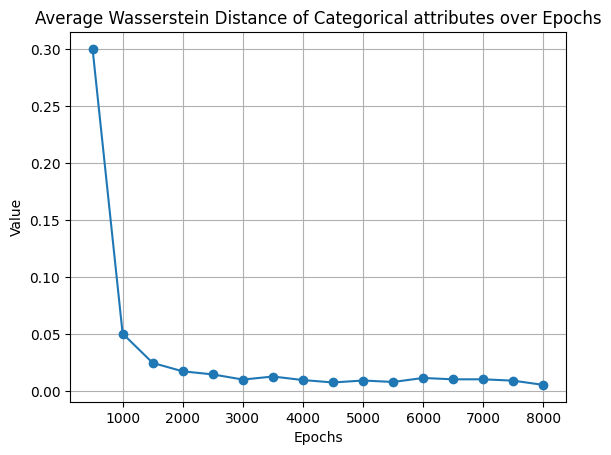

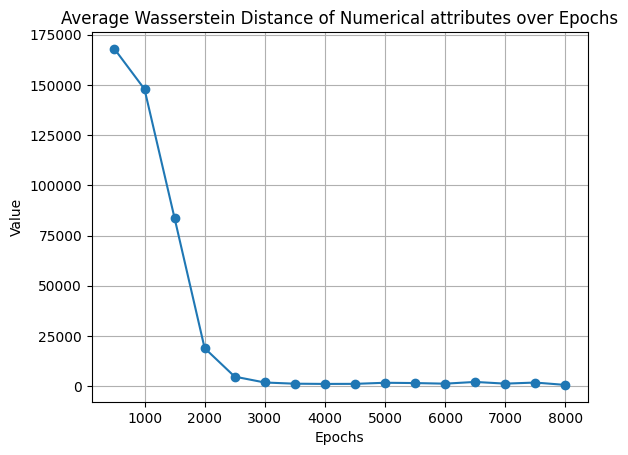

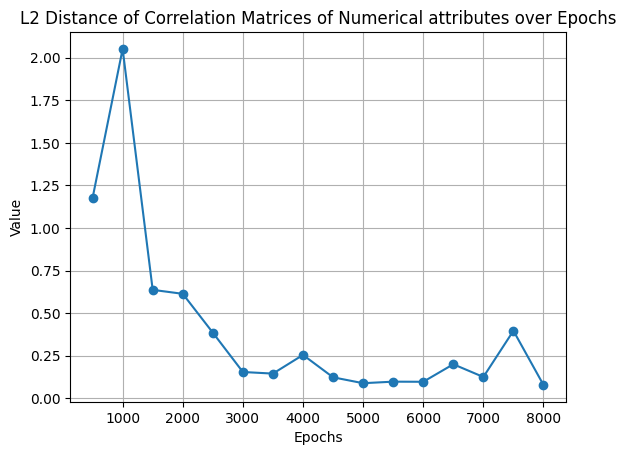

In [ ]:
import matplotlib.pyplot as plt

values = avg_cat_w_distances
epochs = [500 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Categorical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = avg_num_w_distances
epochs = [500 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = corr_l2_distances
epochs = [500 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Saving generated data

In [ ]:
final_df

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,fnlwgt,education-num,hours-per-week,income
0,Private,Assoc-acdm,Never-married,Other-service,Own-child,White,Female,United-States,23.0,201034.896286,11.0,35.0,<=50K
1,Self-emp-not-inc,Some-college,Never-married,Craft-repair,Own-child,White,Male,United-States,19.0,339389.422318,10.0,14.634929,<=50K
2,Private,10th,Divorced,Sales,Not-in-family,White,Female,United-States,28.0,97017.282212,6.0,39.016047,<=50K
3,Private,11th,Married-civ-spouse,Sales,Husband,White,Male,United-States,55.0,185797.473056,7.0,40.0,<=50K
4,Private,Assoc-voc,Never-married,Machine-op-inspct,Other-relative,White,Male,United-States,22.0,172485.37666,11.0,40.0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Private,Bachelors,Never-married,Exec-managerial,Own-child,White,Female,United-States,22.0,103361.763684,13.0,50.0,<=50K
4996,Private,Some-college,Never-married,Machine-op-inspct,Not-in-family,Black,Female,United-States,24.0,172282.327265,10.0,40.0,<=50K
4997,Private,Some-college,Never-married,Exec-managerial,Not-in-family,White,Male,United-States,47.0,117847.412196,10.0,60.0,<=50K
4998,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,57.0,91247.751347,13.0,40.0,>50K


In [ ]:
final_df.to_csv('tabddpm_samples.csv')
files.download('tabddpm_samples.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step eval

In [ ]:
from scipy.stats import wasserstein_distance


def get_cat_wasserstein_distances(real_data, ctgan_data, column_name):
        real_rel = real_data.groupby(column_name).size().values
        total = sum(real_rel)
        real_rel = real_rel/total

        ctgan_rel = ctgan_data.groupby(column_name).size().values
        total = sum(ctgan_rel)
        ctgan_rel = ctgan_rel/total

        ctgan_distance = wasserstein_distance(real_rel, ctgan_rel)

        return ctgan_distance

In [ ]:
def avg_cat_w_dist(real_data, ctgan_data, discrete_columns):
    dists = 0
    for c in discrete_columns:
        dists += get_cat_wasserstein_distances(real_data, ctgan_data, c)
    avg_dists = dists/len(discrete_columns)
    return avg_dists

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data, numerical_columns):
    dists = 0
    for c in numerical_columns:
        dists += wasserstein_distance(real_data[c], model_data[c])
    avg_dists = dists/len(numerical_columns)
    return avg_dists

In [ ]:
import numpy as np

def L2_of_numerical_correlation_matrices(real_data, model_data, cols):
        # Compute correlation matrices
        df1 = real_data[cols]
        df2 = model_data[cols]
        corr1 = df1[cols].corr().values
        corr2 = df2[cols].corr().values

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance

